# Report Figures - Pt 1

This notebook contains the figures generated for Part I of the HMM report (Theory).


In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Optional
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="hls")

from hidden import dynamics, infer
proj_dir = Path().resolve().parents[1]
plot_dir = proj_dir / "reports" / "figures"

In [3]:
# First define the A and B matrices
a1 = 0.7
a2 = 0.8
a3 = 0.9

b = 0.7

def run_hmm_dynamics(a: float, b: float, n_steps: Optional[int] = 100000):
    A = np.array([[a, 1 - a], [1 - a, a]])
    B = np.array([[b, 1 - b], [1 - b, b]])
    hmm = dynamics.HMM(2, 2)
    hmm.initialize_dynamics(A, B)
    hmm.run_dynamics(n_steps=n_steps)
    return hmm.get_state_ts(), hmm.get_obs_ts()

state_ts1, obs_ts1 = run_hmm_dynamics(a1, b)
state_ts2, obs_ts2 = run_hmm_dynamics(a2, b)
state_ts3, obs_ts3 = run_hmm_dynamics(a3, b)


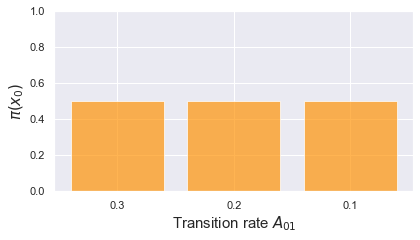

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.bar([0,1,2],[np.mean(state_ts1), np.mean(state_ts2), np.mean(state_ts3)], color=sns.xkcd_rgb["tangerine"], alpha=0.7)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([0.3, 0.2, 0.1])
ax.set_xlabel(r"Transition rate $A_{01}$", fontsize=15)
ax.set_ylabel(r"$\pi(x_0)$", fontsize=15)

ax.set_ylim([0, 1.0])
plt.tight_layout()
plt.savefig(plot_dir / "hmm_sample_stationary_dist.pdf", format='pdf')


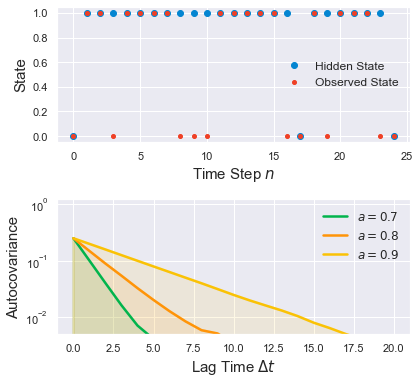

In [5]:
# Now for a chart of the actual dynamics of the two systems, here we should use the actual state and observed states
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5), sharex=False)

ax[0].plot(state_ts1[100:125], 'o', markersize=6, color=sns.xkcd_rgb["cerulean"], label="Hidden State")
ax[0].plot(obs_ts1[100:125], 'o', markersize=4, color=sns.xkcd_rgb["tomato"], label="Observed State")

acf_1 = sm.tsa.acovf(state_ts1, nlag=20)
acf_2 = sm.tsa.acovf(state_ts2, nlag=20)
acf_3 = sm.tsa.acovf(state_ts3, nlag=20)

ax[1].fill_between(range(21), acf_1, linewidth=2.5, color=sns.xkcd_rgb["shamrock"], alpha=0.1)
ax[1].fill_between(range(21), acf_2, linewidth=2.5, color=sns.xkcd_rgb["tangerine"], alpha=0.1)
ax[1].fill_between(range(21), acf_3, linewidth=2.5, color=sns.xkcd_rgb["goldenrod"], alpha=0.1)

ax[1].plot(acf_1, linewidth=2.5, color=sns.xkcd_rgb["shamrock"], label=r"$a = 0.7$")
ax[1].plot(acf_2, linewidth=2.5, color=sns.xkcd_rgb["tangerine"], label=r"$a = 0.8$")
ax[1].plot(acf_3, linewidth=2.5, color=sns.xkcd_rgb["goldenrod"], label=r"$a = 0.9$")

ax[1].set_yscale('log')
ax[1].set_ylim([0.005, 1.25])

ax[0].set_xlabel(r"Time Step $n$", fontsize=15)
ax[0].set_ylabel(r"State", fontsize=15)
ax[0].legend(fontsize=12, frameon=False)

ax[1].set_xlabel(r"Lag Time $\Delta t$", fontsize=15)
ax[1].set_ylabel(r"Autocovariance", fontsize=15)
ax[1].legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig(plot_dir / "hmm_acf_sample.pdf", format="pdf")
plt.show()

In [46]:
# Now focus in on the a=0.9 scenario
a = 0.9
b = 0.75

A = np.array([[a, 1 - a],[1 - a, a]])
B = np.array([[b, 1 - b],[1 - b, b]])

hmm = dynamics.HMM(2, 2)
hmm.initialize_dynamics(A, B)
hmm.run_dynamics(1000)
obs_ts, state_ts = hmm.get_obs_ts(), hmm.get_state_ts()

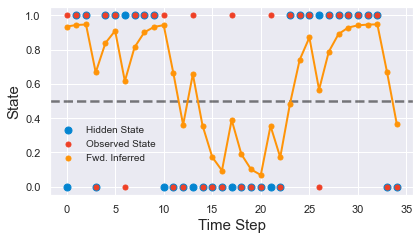

In [69]:

est = infer.MarkovInfer(2, 2)
est.forward_algo(obs_ts, A, B)
est.backward_algo(obs_ts, A, B)
est.bayesian_smooth(A)

prob1_fwd = [p[1] for p in est.forward_tracker]
prob1_rev = [p[1] for p in est.backward_tracker]
prob1_smooth = [p[1] for p in est.bayes_smoother]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.axhline(0.5, linestyle='--', linewidth=2.5, alpha=0.5, color='k')

ax.plot(state_ts[25:60], 'o', markersize=7, color=sns.xkcd_rgb["cerulean"], label="Hidden State")
ax.plot(obs_ts[25:60], 'o', markersize=5, color=sns.xkcd_rgb["tomato"], label="Observed State")
ax.plot(prob1_fwd[25:60], linewidth=2.0, color=sns.xkcd_rgb["tangerine"])
ax.plot(prob1_fwd[25:60], 'o', markersize=5, color=sns.xkcd_rgb["tangerine"], label="Fwd. Inferred")
ax.legend(fontsize=10, frameon=False, loc=(0.01,0.15))

ax.set_ylabel(r"State", fontsize=15)
ax.set_xlabel(r"Time Step", fontsize=15)
plt.tight_layout()
plt.savefig(plot_dir / "schematic_state_filter_v1.pdf", format='pdf')
plt.show()


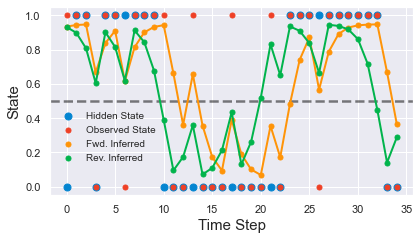

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.axhline(0.5, linestyle='--', linewidth=2.5, alpha=0.5, color='k')

ax.plot(state_ts[25:60], 'o', markersize=7, color=sns.xkcd_rgb["cerulean"], label="Hidden State")
ax.plot(obs_ts[25:60], 'o', markersize=5, color=sns.xkcd_rgb["tomato"], label="Observed State")
ax.plot(prob1_fwd[25:60], linewidth=2.0, color=sns.xkcd_rgb["tangerine"])
ax.plot(prob1_fwd[25:60], 'o', markersize=5, color=sns.xkcd_rgb["tangerine"], label="Fwd. Inferred")
ax.plot(prob1_rev[25:60], linewidth=2.0, color=sns.xkcd_rgb["shamrock"])
ax.plot(prob1_rev[25:60], 'o', markersize=5, color=sns.xkcd_rgb["shamrock"], label="Rev. Inferred")
ax.legend(fontsize=10, frameon=False, loc=(0.01,0.15))

ax.set_ylabel(r"State", fontsize=15)
ax.set_xlabel(r"Time Step", fontsize=15)
plt.tight_layout()
plt.savefig(plot_dir / "schematic_state_filter_v2.pdf", format='pdf')
plt.show()

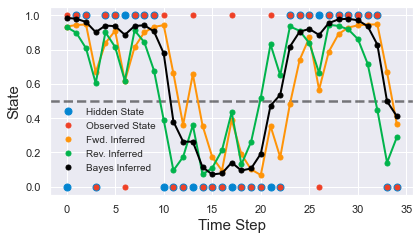

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.axhline(0.5, linestyle='--', linewidth=2.5, alpha=0.5, color='k')

ax.plot(state_ts[25:60], 'o', markersize=7, color=sns.xkcd_rgb["cerulean"], label="Hidden State")
ax.plot(obs_ts[25:60], 'o', markersize=5, color=sns.xkcd_rgb["tomato"], label="Observed State")
ax.plot(prob1_fwd[25:60], linewidth=2.0, color=sns.xkcd_rgb["tangerine"])
ax.plot(prob1_fwd[25:60], 'o', markersize=5, color=sns.xkcd_rgb["tangerine"], label="Fwd. Inferred")
ax.plot(prob1_rev[25:60], linewidth=2.0, color=sns.xkcd_rgb["shamrock"])
ax.plot(prob1_rev[25:60], 'o', markersize=5, color=sns.xkcd_rgb["shamrock"], label="Rev. Inferred")
ax.plot(prob1_smooth[25:60], linewidth=2.0, color=sns.xkcd_rgb["black"])
ax.plot(prob1_smooth[25:60], 'o', markersize=5, color=sns.xkcd_rgb["black"], label="Bayes Inferred")


ax.legend(fontsize=10, frameon=False, loc=(0.01,0.1))

ax.set_ylabel(r"State", fontsize=15)
ax.set_xlabel(r"Time Step", fontsize=15)
plt.tight_layout()
plt.savefig(plot_dir / "schematic_state_filter_v3.pdf", format='pdf')
plt.show()